In [2]:
!pip install avalanche-lib==0.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 894.6/894.6 kB 4.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.4/532.4 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.8/452.8 kB 36.6 MB/s eta 0:00:00
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=2805a2ca96fd764f0d251aed3dcbe15643cfa89d2b4df1bd62fd2a2e93554000
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.6.3
    Uninstalling typing_extensions-4.6.3:
      Successfully uninstalled typing_extensions-4.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is n

In [3]:
import argparse
import os
import time
import numpy as np
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Subset
from torchvision import transforms
import torchvision
import math
from slda_model import StreamingLDA
import retrieve_any_layer
from utils import check_ext_mem, check_ram_usage
import torchvision.transforms.functional as F

from avalanche.benchmarks.classic import CORe50

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Get Model Names

In [4]:
model_names = sorted(name for name in models.__dict__
                     if name.islower() and not name.startswith("__")
                     and callable(models.__dict__[name]))

In [5]:
model_names

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'get_model',
 'get_model_builder',
 'get_model_weights',
 'get_weight',
 'googlenet',
 'inception_v3',
 'list_models',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 '

# Average Pooling Function

In this cell, we define the `pool_feat` function, which performs average pooling on a 4D tensor. This function is commonly used in deep learning and image processing to aggregate spatial features.

In [6]:
def pool_feat(features):
    feat_size = features.shape[-1]
    num_channels = features.shape[1]
    features2 = features.permute(0, 2, 3, 1)  # 1 x feat_size x feat_size x num_channels
    features3 = torch.reshape(features2, (features.shape[0], feat_size * feat_size, num_channels))
    feat = features3.mean(1)  # mb x num_channels
    return feat

# Define the Pre-Trained ResNet-18 Backbone as a Feature Extractor

In [7]:
def get_feature_extraction_model(arch, imagenet_pretrained, feature_size,
                                 num_classes):
    feature_extraction_model = models.__dict__[arch](pretrained=imagenet_pretrained)
    feature_extraction_model.fc = nn.Linear(feature_size, num_classes)
    return feature_extraction_model

# Save Accuracies to JSON

In [8]:
def save_accuracies(accuracies, save_path):
    name = 'accuracies.json'
    json.dump(accuracies, open(os.path.join(save_path, name), 'w'))

# Experimental Results and Data Saving Notebook

In this cell, we define the `save_experimental_results` function. This function is used to save various experimental results, metadata, and model-related information to files in a specified directory. It is a crucial step in documenting and preserving the results of experiments and data analysis.

In [9]:
def save_experimental_results(save_dir, model, valid_acc, elapsed, ram_usage,
                              ext_mem_sz, preds):
    # save experimental meta data:
    # (test accuracies, experiment run-time in minutes, ram usage in MB,
    # external memory size in MB)
    params = {'test_accuracies': valid_acc, 'experiment_time (min)': elapsed,
              'average_ram_usage (MB)': np.average(ram_usage),
              'max_ram_usage (MB)': np.max(ram_usage),
              'average_external_memory_size (MB)': np.average(ext_mem_sz),
              'max_external_memory_size (MB)': np.max(ext_mem_sz)}
    json.dump(params, open(os.path.join(save_dir, 'experimental_meta_data.json'), 'w'))

    # save final model predictions
    json.dump([int(i) for i in preds], open(os.path.join(save_dir, 'final_predictions.json'), 'w'))

    # save final SLDA model weights
    model.save_model(save_dir, 'final_slda_model')

# Loading CORe50 Incremental Batches Based on Scenario

In [10]:
def get_data(args):
    # Create the dataset scenario object
    _mu = [0.485, 0.456, 0.406]  # 
    _std = [0.229, 0.224, 0.225]
    t = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=_mu, std=_std)
    ])
    scenario = CORe50(dataset_root =args.dataset_dir, scenario=args.scenario, train_transform=t, eval_transform=t)
    return scenario

# Loading and Viewing CORe50 Data

In [11]:
def show_sample_images(dataset_dir, scenario):
    t = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    scenario = CORe50(dataset_root =dataset_dir, scenario=scenario, train_transform=t, eval_transform=t)
    
      # loop over the training incremental batches
    for i, batch in enumerate(scenario.train_stream):
        train_loader = DataLoader(batch.dataset, batch_size=64, shuffle=False, num_workers=8)
        
        def imshow(img):
            npimg = img.numpy()
            plt.imshow(np.transpose(npimg, (1, 2, 0)))
            plt.show()

        # get some random training images
        dataiter = iter(train_loader)
        images, labels, _ = next(iter(dataiter))

        # show images
        imshow(torchvision.utils.make_grid(images))
        break

# Experimental Results Plotting

In [12]:
def plot_results(accuracies, title, save_dir):
    fig, ax = plt.subplots(1, 1)

    x = range(1, len(accuracies) + 1)
    ax.plot(x, [a * 100 for a in accuracies], '-o', linewidth=2, markersize=7, alpha=0.8, label='SLDA')

    plt.xlabel('Encountered Batches', fontweight='bold', fontsize=16)
    plt.ylabel('Accuracy [%]', fontweight='bold', fontsize=16)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim([0, 101])

    plt.legend(fontsize=12)
    plt.grid()
    plt.show()
    fig.savefig(os.path.join(save_dir, title + '.png'), bbox_inches="tight", format='png')

# Training SLDA on a New "Batch" of Data

In [13]:
def train(model, feature_extraction_wrapper, train_loader):
    print('\nTraining on %d images.' % len(train_loader.dataset))

    stats = {"ram": [], "disk": []}
    stats['disk'].append(check_ext_mem("cl_ext_mem"))
    stats['ram'].append(check_ram_usage())

    for train_x, train_y, _ in tqdm(train_loader, total=len(train_loader)):
        batch_x_feat = feature_extraction_wrapper(train_x.cuda())
        batch_x_feat = pool_feat(batch_x_feat)

        # train one sample at a time
        for x_pt, y_pt in zip(batch_x_feat, train_y):
            model.fit(x_pt.cpu(), y_pt.view(1, ))

    return stats

# Testing SLDA After Each New "Batch" of Data

In [14]:
def evaluate(model, feature_extraction_wrapper, test_loader):
    print('\nEvaluating on %d images.' % len(test_loader.dataset))

    preds = []
    correct = 0

    for it, (test_x, test_y, _) in tqdm(enumerate(test_loader), total=len(test_loader)):
        batch_x_feat = feature_extraction_wrapper(test_x.cuda())
        batch_x_feat = pool_feat(batch_x_feat)

        logits = model.predict(batch_x_feat, return_probas=True)

        _, pred_label = torch.max(logits, 1)
        correct += (pred_label == test_y).sum()
        preds += list(pred_label.numpy())

    acc = correct.item() / len(test_loader.dataset)
    return acc, preds

# Display Testing images

In [15]:
def display_unique_images(data):
    unique_classes = set()

    # Collect unique class labels up to a maximum of 50
    for item in data:
        class_label = item[1]
        if class_label not in unique_classes:
            unique_classes.add(class_label)
        if len(unique_classes) == 50:
            break

    # Determine grid size based on the number of unique classes
    num_rows = 5
    num_cols = 10
    max_images = len(unique_classes)
    actual_rows = -(-(max_images) // num_cols)  # Ceiling division

    fig, axes = plt.subplots(actual_rows, num_cols, figsize=(15, 1.5 * actual_rows))
    axes = axes.ravel() if actual_rows > 1 or num_cols > 1 else [axes]  # Ensure axes is always a list

    current_index = 0
    displayed_classes = set()

    for item in data:
        class_label = item[1]

        if class_label not in displayed_classes:
            displayed_classes.add(class_label)
            
            image = item[0]
            axes[current_index].imshow(image.permute(1, 2, 0))
            axes[current_index].set_title(f"Class: {class_label}")
            axes[current_index].axis('off')
            
            current_index += 1

            if current_index >= max_images:
                break

    # Turn off any remaining axes
    for ax in axes[current_index:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [16]:
# Define a function to create a test DataLoader with classes 0 to 9
def create_test_loader_for_classes(dataset, num_classes=10, batch_size=64):
    # Filter the dataset to include only samples from classes 0 to 9
    filtered_indices = [i for i, (_, label, _) in enumerate(dataset) if label < num_classes]
    filtered_subset = Subset(dataset, filtered_indices)

    # Create the dataset scenario object
    _mu = [0.485, 0.456, 0.406]  # imagenet normalization
    _std = [0.229, 0.224, 0.225]
    t = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=_mu, std=_std)
    ])


    # Create a DataLoader for the filtered subset
    test_loader = DataLoader(filtered_subset, batch_size=batch_size,  shuffle=False, num_workers=8)

    return test_loader

# Training/Evaluation Setup

In [17]:
def main(args):
    # start timing experiment
    start = time.time()

    scenario = get_data(args)
    test_loader = None
    test_loader_subset = None
    for i, batch in enumerate(scenario.test_stream):
        test_loader = DataLoader(batch.dataset, batch_size=args.batch_size, shuffle=False, num_workers=8)
        test_loader_subset = create_test_loader_for_classes(batch.dataset, num_classes=10, batch_size=args.batch_size)
        
        #display_unique_images(batch.dataset)
    
    # create SLDA model
    model = StreamingLDA(args.feature_size, args.n_classes,
                         test_batch_size=args.batch_size,
                         shrinkage_param=args.shrinkage,
                         streaming_update_sigma=args.plastic_cov)

    # create feature extraction model pre-trained on imagenet
    feature_extraction_model = get_feature_extraction_model(arch=args.arch,
                                                            imagenet_pretrained=True,
                                                            feature_size=args.feature_size,
                                                            num_classes=args.n_classes)
    
    # layer 4.1 is the final layer in resnet18 (need to change this code
    # for other architectures)
    feature_extraction_wrapper = retrieve_any_layer.ModelWrapper(
        feature_extraction_model.eval().cuda(),
        ['layer4.1'], return_single=True).eval()

    # variables to update over time
    forget = []
    test_acc = []
    ext_mem_sz = []
    ram_usage = []
    total_forgetting = 0
    batch_count = 0

    # loop over the training incremental batches
    for i, batch in enumerate(scenario.train_stream):
        print("\n----------- Batch {0}/{1} -------------".format(i + 1, len(scenario.train_stream)))
        train_loader = DataLoader(batch.dataset, batch_size=args.batch_size, shuffle=False, num_workers=8)
        
        #display_unique_images(batch.dataset)

        # fit SLDA model to batch (one sample at a time)
        stats = train(model, feature_extraction_wrapper, train_loader)

        # save SLDA model weights after current batch has been fit
        model.save_model(args.save_dir, 'slda_model_batch_%d' % i)

        # evaluate model on test data
        acc, preds = evaluate(model, feature_extraction_wrapper, test_loader)
        #f, preds = evaluate(model, feature_extraction_wrapper, test_loader_subset)                                                

        print("------------------------------------------")
        print("Test Accuracy: %0.3f" % acc)
#         print("------------------------------------------")
#         print("------------------------------------------")
#         print("Forget: %0.3f" % f)
#         print("------------------------------------------")                                                

        # update stats
        forget += [f]                                                
        test_acc += [acc]
        ext_mem_sz += stats['disk']
        ram_usage += stats['ram']
        total_forgetting += f
        batch_count += 1

        # update test accuracy list
        save_accuracies(test_acc, args.save_dir)
        
    overall_forgetting = total_forgetting / batch_count    
    print(f"Overall Average Forgetting: {overall_forgetting}")
    # total elapsed time
    elapsed = (time.time() - start) / 60
    print("Total Experiment Time: %0.2f minutes" % elapsed)

    # save experimental results
    save_experimental_results(args.save_dir, model, test_acc, elapsed, ram_usage, ext_mem_sz, preds)

    # plot final results
    plot_results(test_acc, 'incremental_performance', args.save_dir)
    # plot final results
    #plot_results(forget, 'forget', args.save_dir)                                                        

# Experiment Setup and Configuration

Arguments {
    "arch": "resnet18",
    "batch_size": 512,
    "dataset_dir": "/kaggle/working/",
    "feature_size": 512,
    "n_classes": 1000,
    "plastic_cov": true,
    "save_dir": "results/nc",
    "scenario": "nc",
    "shrinkage": 0.0001
}
Loading labels...
Loading LUP...
Loading labels names...
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


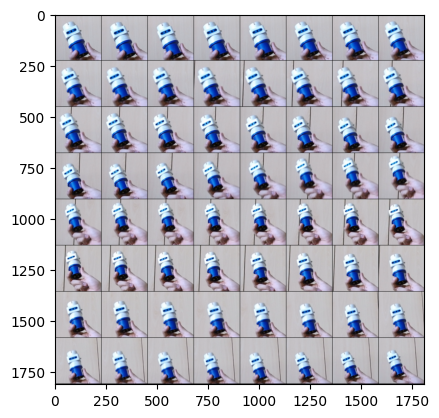

Loading labels...
Loading LUP...
Loading labels names...
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s] 



----------- Batch 1/9 -------------

Training on 23980 images.


100%|██████████| 47/47 [00:52<00:00,  1.12s/it]


Evaluating on 44972 images.



100%|██████████| 88/88 [01:05<00:00,  1.34it/s]


Evaluating on 8993 images.



100%|██████████| 18/18 [00:16<00:00,  1.08it/s]


------------------------------------------
Test Accuracy: 0.192

----------- Batch 2/9 -------------

Training on 11993 images.


100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


Evaluating on 44972 images.



100%|██████████| 88/88 [01:09<00:00,  1.27it/s]


Evaluating on 8993 images.



100%|██████████| 18/18 [00:16<00:00,  1.08it/s]


------------------------------------------
Test Accuracy: 0.280

----------- Batch 3/9 -------------

Training on 11990 images.


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]


Evaluating on 44972 images.



100%|██████████| 88/88 [01:09<00:00,  1.26it/s]


Evaluating on 8993 images.



100%|██████████| 18/18 [00:17<00:00,  1.04it/s]


------------------------------------------
Test Accuracy: 0.355

----------- Batch 4/9 -------------

Training on 11993 images.


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]



Evaluating on 44972 images.


100%|██████████| 88/88 [01:10<00:00,  1.25it/s]


Evaluating on 8993 images.



100%|██████████| 18/18 [00:16<00:00,  1.07it/s]


------------------------------------------
Test Accuracy: 0.434

----------- Batch 5/9 -------------

Training on 11989 images.


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]



Evaluating on 44972 images.


100%|██████████| 88/88 [01:10<00:00,  1.25it/s]


Evaluating on 8993 images.



100%|██████████| 18/18 [00:16<00:00,  1.07it/s]


------------------------------------------
Test Accuracy: 0.504

----------- Batch 6/9 -------------

Training on 11979 images.


100%|██████████| 24/24 [00:29<00:00,  1.22s/it]



Evaluating on 44972 images.


100%|██████████| 88/88 [01:09<00:00,  1.26it/s]


Evaluating on 8993 images.



100%|██████████| 18/18 [00:17<00:00,  1.04it/s]


------------------------------------------
Test Accuracy: 0.570

----------- Batch 7/9 -------------

Training on 11990 images.


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]



Evaluating on 44972 images.


100%|██████████| 88/88 [01:10<00:00,  1.25it/s]


Evaluating on 8993 images.



100%|██████████| 18/18 [00:16<00:00,  1.07it/s]


------------------------------------------
Test Accuracy: 0.633

----------- Batch 8/9 -------------

Training on 11987 images.


100%|██████████| 24/24 [00:28<00:00,  1.19s/it]



Evaluating on 44972 images.


100%|██████████| 88/88 [01:10<00:00,  1.25it/s]


Evaluating on 8993 images.



100%|██████████| 18/18 [00:17<00:00,  1.06it/s]


------------------------------------------
Test Accuracy: 0.718

----------- Batch 9/9 -------------

Training on 11993 images.


100%|██████████| 24/24 [00:28<00:00,  1.20s/it]



Evaluating on 44972 images.


100%|██████████| 88/88 [01:10<00:00,  1.26it/s]


Evaluating on 8993 images.



100%|██████████| 18/18 [00:17<00:00,  1.02it/s]


------------------------------------------
Test Accuracy: 0.797
Overall Average Forgetting: 0.8801784103685583
Total Experiment Time: 19.52 minutes


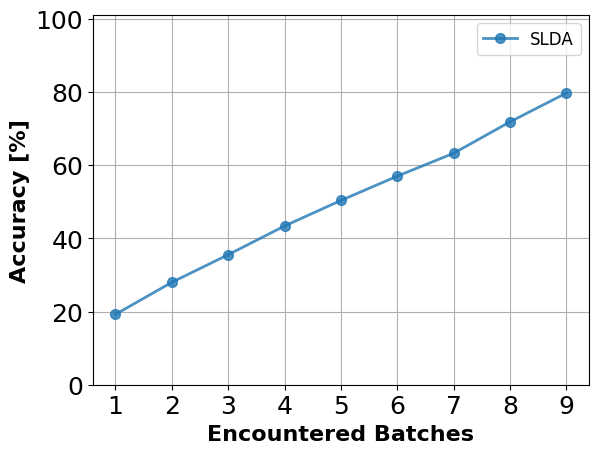

In [18]:
if __name__ == "__main__":
    import argparse

    if 'ipykernel' in sys.modules:
        # Running in a Jupyter notebook, provide default arguments
        args = argparse.Namespace(
            n_classes=1000,
            scenario="nc",
            dataset_dir="/kaggle/working/",
            save_dir="results",
            arch="resnet18",
            feature_size=512,
            shrinkage=1e-4,
            plastic_cov=True,
            batch_size=512
        )
    else:
        parser = argparse.ArgumentParser('SLDA Tutorial on CORe50')

        # Define your command-line arguments as before
        # ...
        # general parameters
        parser.add_argument('--n_classes', type=int, default=50)
        parser.add_argument('--scenario', type=str, default="nc",
                            choices=['ni', 'nc', 'nic', 'nicv2_79', 'nicv2_196',
                                     'nicv2_391'])
        parser.add_argument('--dataset_dir', type=str,
                            default='/kaggle/working/')
        parser.add_argument('--save_dir', type=str, default="results",
                            help='directory to save experimental results')

        # model parameters
        parser.add_argument('--arch', type=str, default='resnet18',
                            choices=['resnet18'])
        parser.add_argument('--feature_size', type=int,
                            default=512)  # feature size before output layer
        parser.add_argument('--shrinkage', type=float,
                            default=1e-4)  # shrinkage value
        parser.add_argument('--plastic_cov', type=bool,
                            default=True)  # plastic covariance matrix
        parser.add_argument('--batch_size', type=int, default=512)


        args = parser.parse_args()

    args.save_dir = os.path.join(args.save_dir, args.scenario)
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)

     # print args and save to json file
    print(
        "Arguments {}".format(json.dumps(vars(args), indent=4, sort_keys=True)))
    json.dump(vars(args),
              open(os.path.join(args.save_dir, 'parameter_arguments.json'),
                   'w'))

    show_sample_images(args.dataset_dir, args.scenario)

    main(args)

# Real Time

In [20]:
import os  # Add this import statement
import cv2
import torch
import numpy as np
from torchvision import transforms
from slda_model import StreamingLDA  # Import your SLDA model class
import retrieve_any_layer

# Function to preprocess an image before feeding it to the model
def preprocess_image(frame):
    # Resize the frame to (224, 224) and convert to torch tensor
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    
    preprocessed_frame = transform(frame)
    return preprocessed_frame

# Function to classify an image using the SLDA model
def classify_image(model, feature_extraction_wrapper, image):
    # Preprocess the image
    preprocessed_image = preprocess_image(image)

    # Convert to tensor and add batch dimension
    input_tensor = torch.unsqueeze(preprocessed_image, 0).cuda()

    # Extract features using the feature extraction model
    features = feature_extraction_wrapper(input_tensor)

    # Pool the features (you may need to adapt based on your model architecture)
    pooled_features = pool_feat(features)

    # Use the SLDA model for prediction
    predictions = model.predict(pooled_features, return_probas=True)

    # Get the predicted class
    _, predicted_class = torch.max(predictions, 1)

    return predicted_class.item()

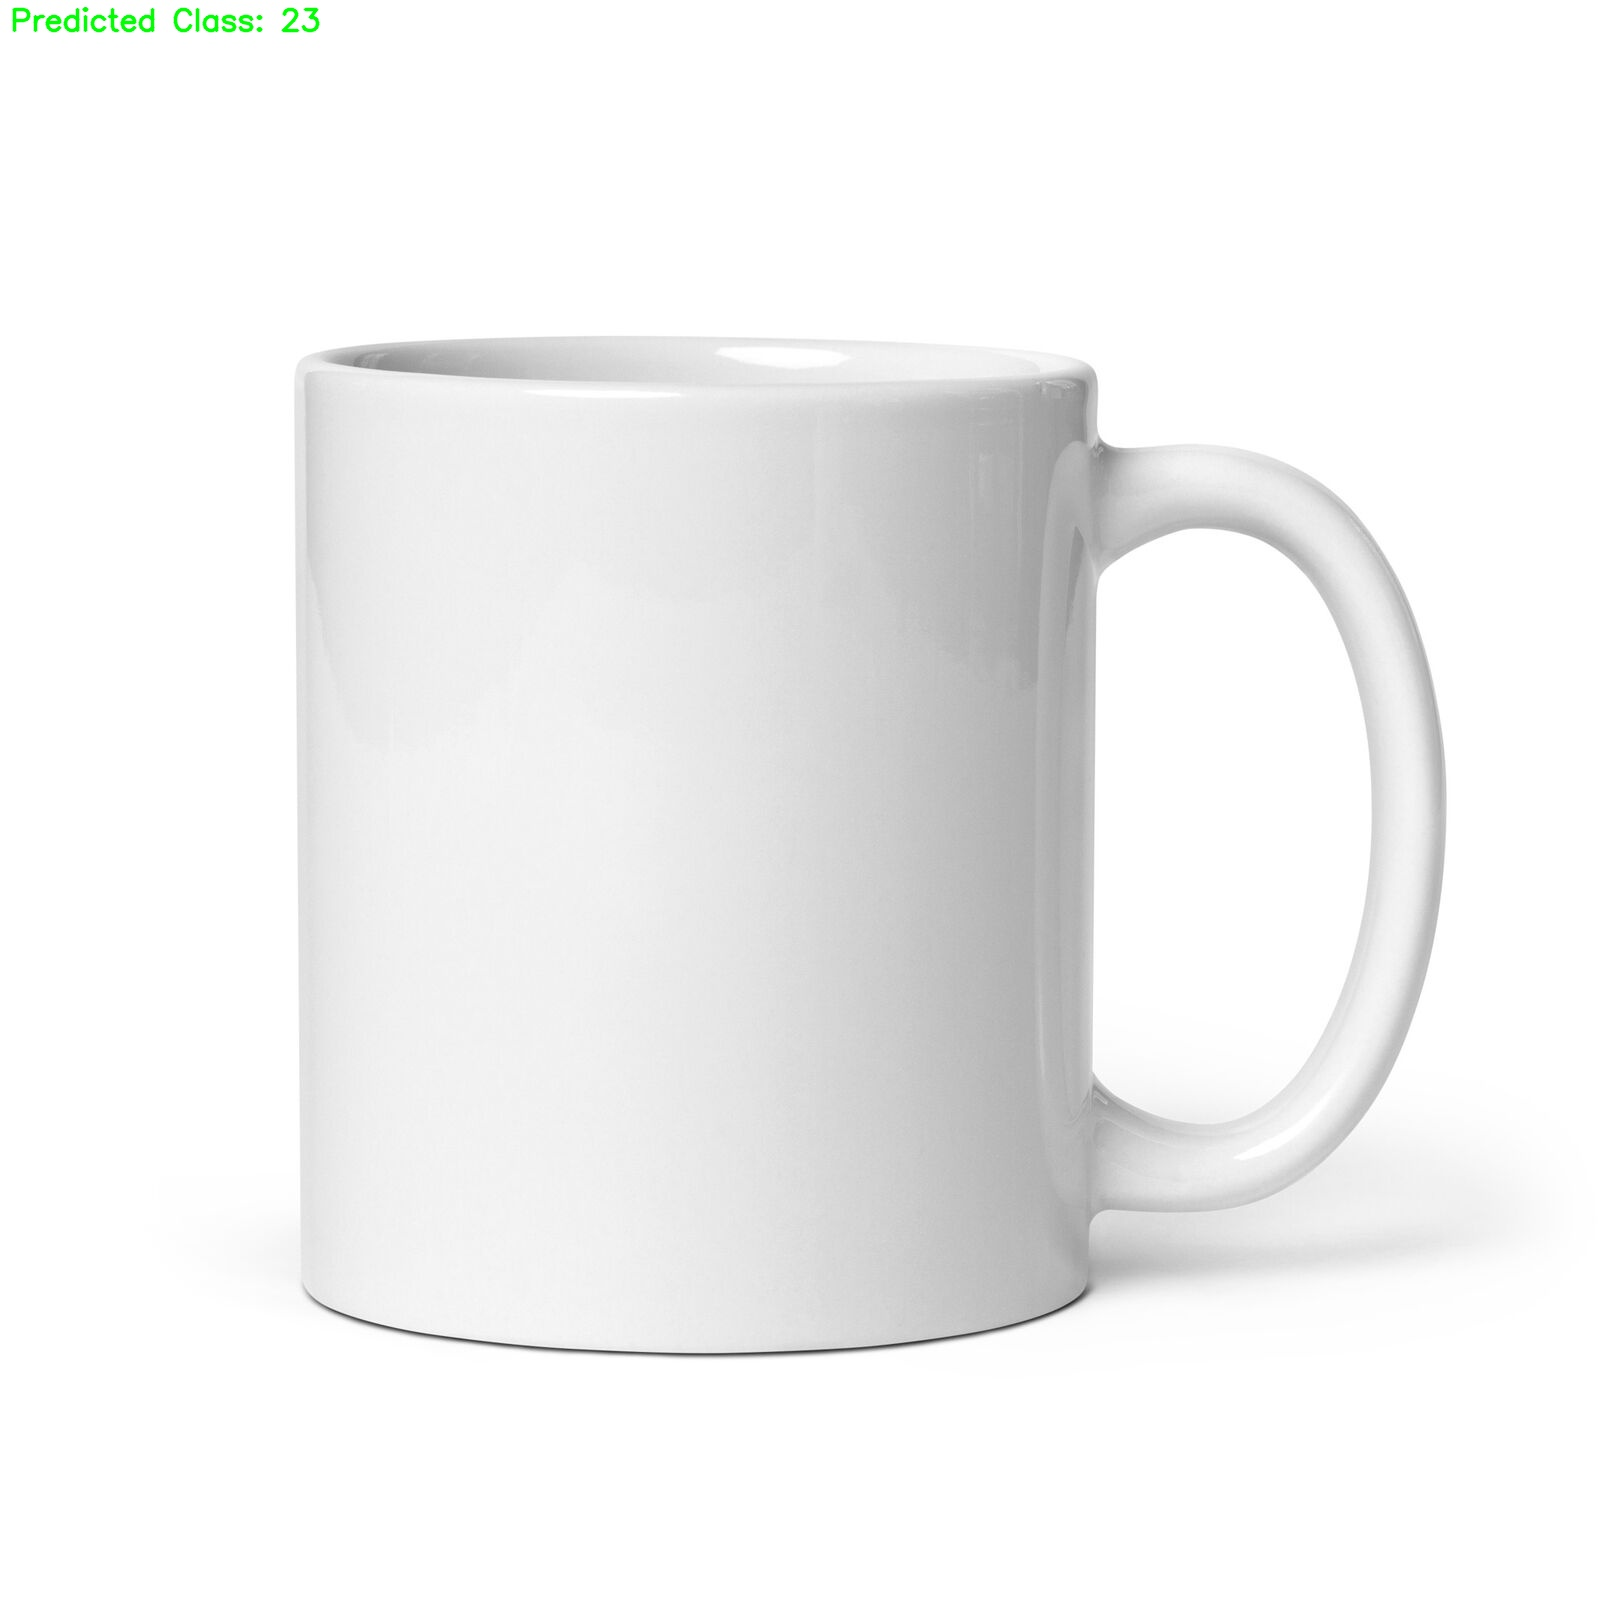

In [25]:
from IPython.display import display, Image
import cv2
def main():
    # Load your trained SLDA model
    model = StreamingLDA(input_shape=512, num_classes=1000)
    model.load_model(save_path='/kaggle/working/results/nc/', save_name='final_slda_model')  # Adjust the path

    # Create the feature extraction model (similar to the training script)
    feature_extraction_model = get_feature_extraction_model(
        arch='resnet18', imagenet_pretrained=True, feature_size=512, num_classes=1000)
    feature_extraction_wrapper = retrieve_any_layer.ModelWrapper(
        feature_extraction_model.eval().cuda(),
        ['layer4.1'], return_single=True).eval()

    # Example: Use a static image for testing (replace with your image path)
    image_path = '/kaggle/input/cupimage/cup.jpg'
    frame = cv2.imread(image_path)

    # Check if the frame is None
    if frame is None:
        print("Failed to read the image. Make sure the image path is correct.")
    else:
        # Classify the captured frame
        predicted_class = classify_image(model, feature_extraction_wrapper, frame)

        # Display the result on the frame
        cv2.putText(frame, f'Predicted Class: {predicted_class}', (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Display the frame using IPython.display
        display(Image(data=cv2.imencode('.jpg', frame)[1]))

if __name__ == "__main__":
    main()